### Online machine learning
- Incremental learning experiments

In [1]:
import os
import re
from zipfile import ZipFile
from pprint import pprint
from collections import defaultdict

import sys
sys.path.append('../')
from vibrodiagnostics import (
    mafaulda, selection, discovery, models
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import functools
from sklearn import metrics as skmetrics
import river
from river import (
    anomaly,
    cluster,
    neighbors,
    preprocessing,
    evaluate,
    stream,
    metrics,
    feature_selection,
    stats
)
import tsfel


PATH_PREFIX = '../../datasets/'
FEATURES_PATH =  os.path.join(PATH_PREFIX, 'features_data')

DATASET_PATH = os.path.join(PATH_PREFIX, 'MAFAULDA.zip')
MAFAULDA_METADATA = os.path.join(FEATURES_PATH, 'mafaulda_metadata.csv')

TD_FEATURES = os.path.join(FEATURES_PATH, selection.TIME_FEATURES_PATH)
FD_FEATURES = os.path.join(FEATURES_PATH, selection.FREQ_FEATURES_PATH)
TD_FD_FEATURES = os.path.join(FEATURES_PATH, selection.TIME_AND_FREQ_FEATURES_PATH)

TSFEL_FEATURES = os.path.join(FEATURES_PATH, selection.TSFEL_FEATURES_PATH)
TSFEL_TD_FEATURES = os.path.join(FEATURES_PATH, selection.TSFEL_TIME_FEATURES_PATH)
TSFEL_FD_FEATURES = os.path.join(FEATURES_PATH, selection.TSFEL_FREQ_FEATURES_PATH)
TSFEL_SD_FEATURES = os.path.join(FEATURES_PATH, selection.TSFEL_STAT_FEATURES_PATH)


FEATURES_FILENAME = FD_FEATURES

### Evolution of classes in dataset
- [ ] Faults over observations (number of seen until observation)
- [ ] Fault severity
- [ ] Anomaly (classes and percentages)

In [2]:
def plot_label_occurences(y):
    observations = []
    columns = list(y.astype('category').cat.categories)
    empty = dict(zip(columns, len(columns) * [0]))

    for row in y.astype('category').cat.codes:
        sample = empty.copy()
        sample[row] = 1
        observations.append(sample)

    class_occurences = pd.DataFrame.from_records(observations).cumsum()
    class_occurences.plot(grid=True, figsize=(10, 3), xlabel='Observations', ylabel='Label occurences')

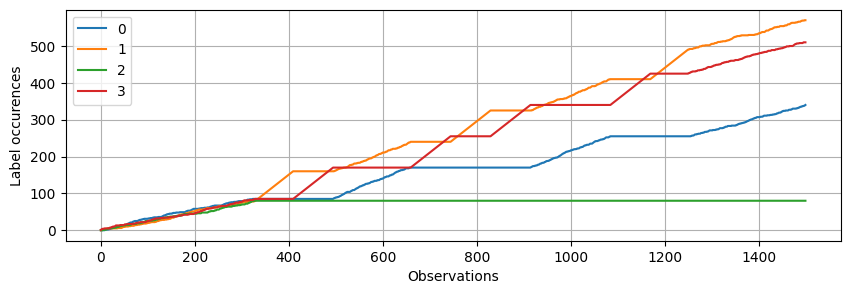

In [3]:
X, y = models.features_subset(FEATURES_FILENAME, selection.FAULT_CLASSES, ['az'], 'fault')
plot_label_occurences(y)
plt.show()

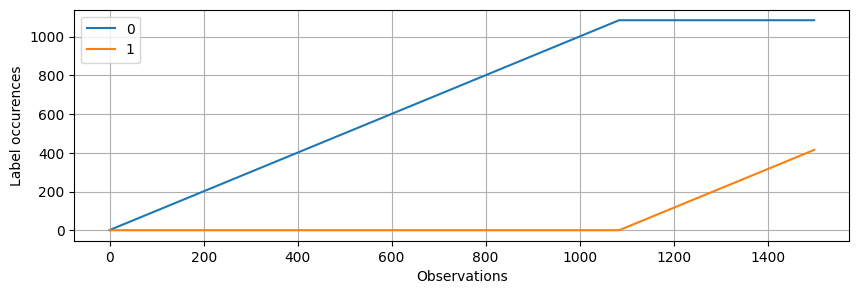

In [4]:
X, y = models.features_subset(FEATURES_FILENAME, selection.FAULT_CLASSES, ['az'], 'anomaly')
plot_label_occurences(y)
plt.show()

### Half-space trees (Anomaly)

#### HST: Parameter = Trees

/home/miroslav/.virtualenvs/dp/lib/python3.11/site-packages/river/preprocessing/scale.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return a / b if b else 0.0


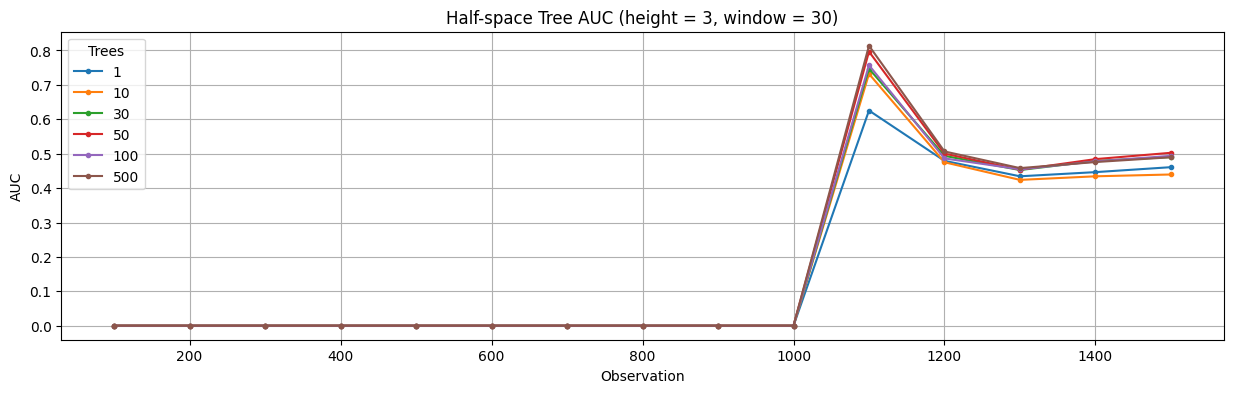

,1,10,30,50,100,500
Step,,,,,,
1500,0.460808,0.439562,0.490227,0.502627,0.493818,0.48971


In [5]:
X, y = models.features_subset(FEATURES_FILENAME, selection.FAULT_CLASSES, ['az'], 'anomaly')

results = []
for tree in (1, 10, 30, 50, 100, 500):
    hst = (
        preprocessing.MinMaxScaler() |
        anomaly.HalfSpaceTrees(n_trees=tree, height=3, window_size=30, seed=10)
    )
    steps = evaluate.iter_progressive_val_score(
        model=hst,
        dataset=stream.iter_pandas(X, y),
        metric=metrics.ROCAUC(),
        step=100
    )
    evolution = []
    for step in steps:
        evolution.append({
            'Step': step['Step'],
            tree: step['ROCAUC'].get()
        })

    evolution = pd.DataFrame.from_records(evolution).set_index('Step')
    results.append(evolution)

results = functools.reduce(lambda a, b: pd.merge(a, b, on=['Step'], how='inner'), results)
ax = results.plot(grid=True, figsize=(15, 4), title='Half-space Tree AUC (height = 3, window = 30)', xlabel='Observation', ylabel='AUC', marker='.')
ax.legend(title='Trees')
plt.show()
results.tail(1)

#### HST: Parameter = Window size

/home/miroslav/.virtualenvs/dp/lib/python3.11/site-packages/river/preprocessing/scale.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return a / b if b else 0.0


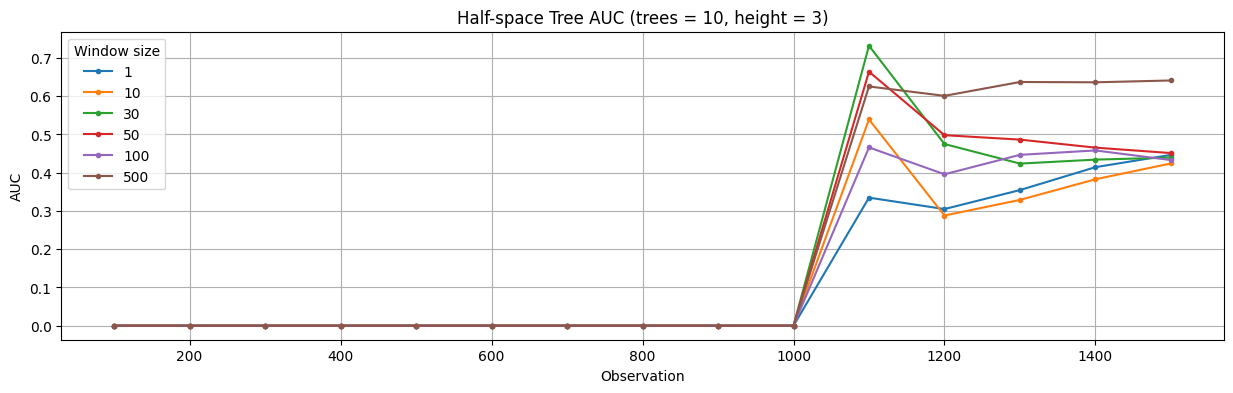

,1,10,30,50,100,500
Step,,,,,,
1500,0.446686,0.424303,0.439562,0.451389,0.433088,0.641216


In [6]:
X, y = models.features_subset(FEATURES_FILENAME, selection.FAULT_CLASSES, ['az'], 'anomaly')

results = []
for window in (1, 10, 30, 50, 100, 500):
    hst = (
        preprocessing.MinMaxScaler() |
        anomaly.HalfSpaceTrees(n_trees=10, height=3, window_size=window, seed=10)
    )
    steps = evaluate.iter_progressive_val_score(
        model=hst,
        dataset=stream.iter_pandas(X, y),
        metric=metrics.ROCAUC(),
        step=100
    )
    evolution = []
    for step in steps:
        evolution.append({
            'Step': step['Step'],
            window: step['ROCAUC'].get()
        })

    evolution = pd.DataFrame.from_records(evolution).set_index('Step')
    results.append(evolution)

results = functools.reduce(lambda a, b: pd.merge(a, b, on=['Step'], how='inner'), results)
ax = results.plot(grid=True, figsize=(15, 4), title='Half-space Tree AUC (trees = 10, height = 3)', xlabel='Observation', ylabel='AUC', marker='.')
ax.legend(title='Window size')
plt.show()
results.tail(1)

#### HST: Parameter = Height of tree

/home/miroslav/.virtualenvs/dp/lib/python3.11/site-packages/river/preprocessing/scale.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return a / b if b else 0.0


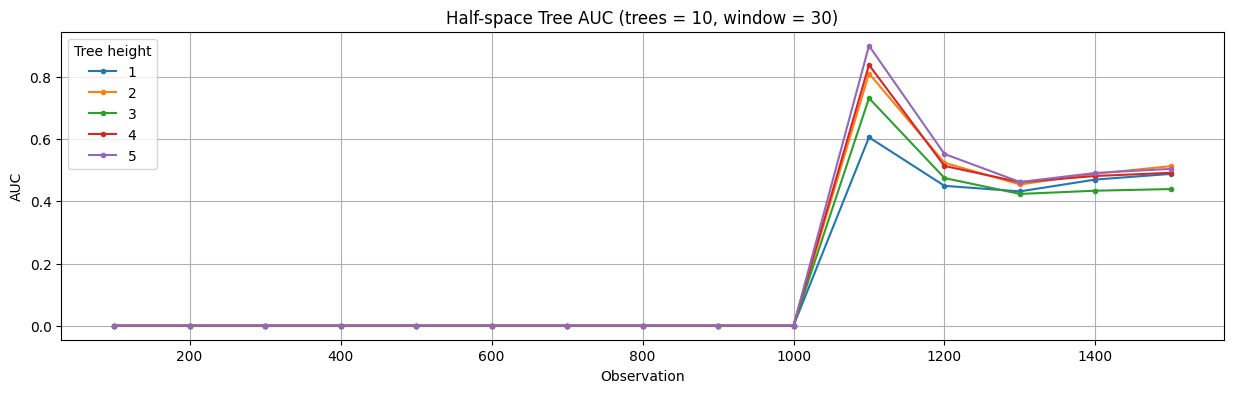

,1,2,3,4,5
Step,,,,,
1500,0.488339,0.513202,0.439562,0.491886,0.504528


In [7]:
X, y = models.features_subset(FEATURES_FILENAME, selection.FAULT_CLASSES, ['az'], 'anomaly')

results = []
for height in (1, 2, 3, 4, 5):
    hst = (
        preprocessing.MinMaxScaler() |
        anomaly.HalfSpaceTrees(n_trees=10, height=height, window_size=30, seed=10)
    )
    steps = evaluate.iter_progressive_val_score(
        model=hst,
        dataset=stream.iter_pandas(X, y),
        metric=metrics.ROCAUC(),
        step=100
    )
    evolution = []
    for step in steps:
        evolution.append({
            'Step': step['Step'],
            height: step['ROCAUC'].get()
        })

    evolution = pd.DataFrame.from_records(evolution).set_index('Step')
    results.append(evolution)

results = functools.reduce(lambda a, b: pd.merge(a, b, on=['Step'], how='inner'), results)
ax = results.plot(grid=True, figsize=(15, 4), title='Half-space Tree AUC (trees = 10, window = 30)', xlabel='Observation', ylabel='AUC', marker='.')
ax.legend(title='Tree height')
plt.show()
results.tail(1)

#### HST: Classification clusters

/home/miroslav/.virtualenvs/dp/lib/python3.11/site-packages/river/preprocessing/scale.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return a / b if b else 0.0
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


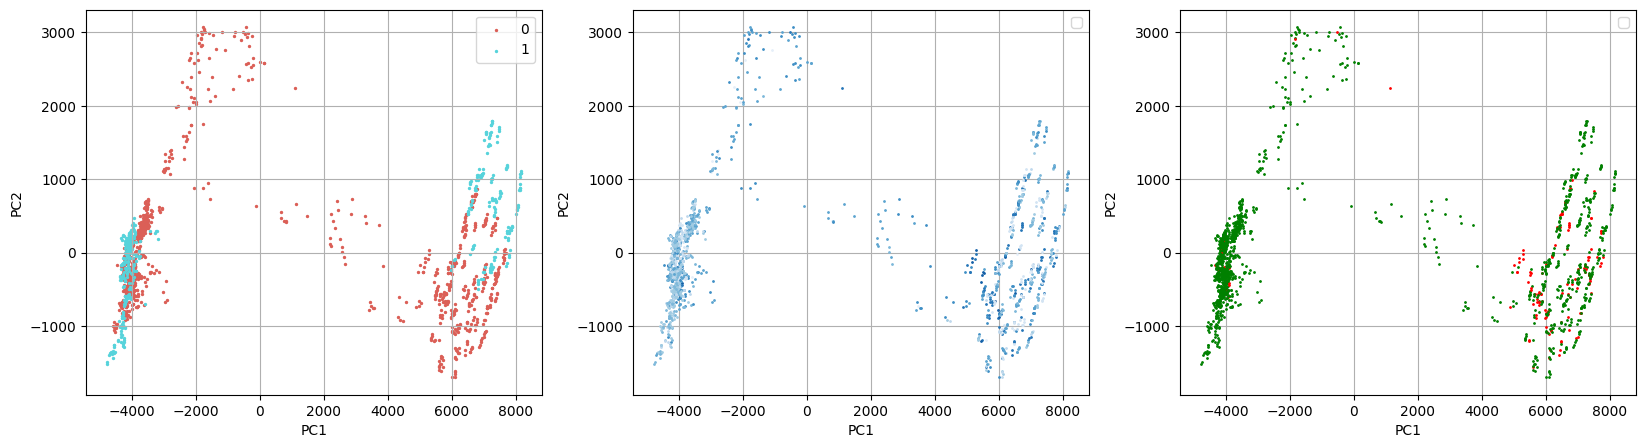

In [8]:
def hst_visualize_classes(X, y):
    hst = (
        preprocessing.MinMaxScaler() |
        anomaly.HalfSpaceTrees(n_trees=10, height=3, window_size=30, seed=10)
    )
    y_scores = []
    for xs, ys in stream.iter_pandas(X, y):
        score = hst.score_one(xs)
        hst.learn_one(xs)
        y_scores.append(score)

    y_scores = np.array(y_scores)
    models.project_anomaly_map_plot(X, y, y_scores)


X, y = models.features_subset(FEATURES_FILENAME, selection.FAULT_CLASSES, ['az'], 'anomaly')
hst_visualize_classes(X, y)